In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import polars as pl
import numpy as np
import gc
#from scipy.stats import skew, kurtosis
from itertools import combinations
import lightgbm as lgb
from pathlib import Path

import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Optiver/data")

In [ ]:
train = pd.read_parquet(data_dir/'train.parquet')

shape = train.shape
size = shape[0]
#train['rand_feat'] = np.random.rand(size)

print(train.shape)
print()
train.head(3)

(5237980, 17)



,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.0,-3.029704,0,0_0_0
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.040039,1.000660,20605.089844,1.0,-5.519986,0,0_0_1
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,37956.000000,1.000298,18995.000000,1.0,-8.389950,0,0_0_2


In [ ]:
#https://www.kaggle.com/code/gogo827jz/combinatorial-purged-group-k-fold

import numpy as np
from scipy.special import comb
from itertools import combinations

class CombinatorialPurgedGroupKFold():
    def __init__(self, n_splits = 6, n_test_splits = 2, purge = 1, pctEmbargo = 0.01, **kwargs):
        self.n_splits = n_splits
        self.n_test_splits = n_test_splits
        self.purge = purge
        self.pctEmbargo = pctEmbargo

    def split(self, X, y = None, groups = None):
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")

        u, ind = np.unique(groups, return_index = True)
        unique_groups = u[np.argsort(ind)]
        n_groups = len(unique_groups)
        group_dict = {}
        for idx in range(len(X)):
            if groups[idx] in group_dict:
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]

        n_folds = comb(self.n_splits, self.n_test_splits, exact = True)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        mbrg = int(n_groups * self.pctEmbargo)
        if mbrg < 0:
            raise ValueError(
                "The number of 'embargoed' groups should not be negative")

        split_dict = {}
        group_test_size = n_groups // self.n_splits
        for split in range(self.n_splits):
            if split == self.n_splits - 1:
                split_dict[split] = unique_groups[int(split * group_test_size):].tolist()
            else:
                split_dict[split] = unique_groups[int(split * group_test_size):int((split + 1) * group_test_size)].tolist()

        for test_splits in combinations(range(self.n_splits), self.n_test_splits):
            test_groups = []
            banned_groups = []
            for split in test_splits:
                test_groups += split_dict[split]
                banned_groups += unique_groups[split_dict[split][0] - self.purge:split_dict[split][0]].tolist()
                banned_groups += unique_groups[split_dict[split][-1] + 1:split_dict[split][-1] + self.purge + mbrg + 1].tolist()
            train_groups = [i for i in unique_groups if (i not in banned_groups) and (i not in test_groups)]

            train_idx = []
            test_idx = []
            for train_group in train_groups:
                train_idx += group_dict[train_group]
            for test_group in test_groups:
                test_idx += group_dict[test_group]
            yield train_idx, test_idx

In [ ]:
# https://www.kaggle.com/code/konradb/ts-10-validation-methods-for-time-series
n_splits = 5
n_test_splits = 1
elements = list(range(10 * (n_splits + n_test_splits)))
groups = [element // n_splits for element in elements]
data = pd.DataFrame({"group": groups, "element": elements})
kfold = CombinatorialPurgedGroupKFold(n_splits, n_test_splits)
for index, (train_indices, test_indices) in enumerate(kfold.split(data, groups=data["group"])):
    print("=" * 100)
    print(f"Fold {index}")
    print("=" * 100)
    print("Train indices:", train_indices, "Length:", len(train_indices))
    print("Test Indices:", test_indices, "Length:", len(test_indices))

Fold 0
Train indices: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] Length: 45
Test Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] Length: 10
Fold 1
Train indices: [0, 1, 2, 3, 4, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] Length: 40
Test Indices: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19] Length: 10
Fold 2
Train indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] Length: 40
Test Indices: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29] Length: 10
Fold 3
Train indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] Length: 40
Test Indices: [30, 31, 32, 33, 34, 35, 36

In [ ]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]

weights = {int(k):v for k,v in enumerate(weights)}

In [ ]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            #if mid_val == min_val:  # Prevent division by zero
            #    imbalance_features[j, i] = np.nan
            #else:
            imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val + 1e-6)

    return imbalance_features


def calculate_triplet_imbalance_numba(price, df):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    # Calculate the triplet imbalance
    features_array = compute_triplet_imbalance(df_values, comb_indices)

    # Create a DataFrame from the results
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features.astype('float32')

In [ ]:
%%time
def make_features(df):

    fields_int16 = ['stock_id', 'date_id', 'seconds_in_bucket']
    fields_float32 = ['imbalance_size', 'reference_price', 'matched_size',
                      'far_price', 'near_price', 'bid_price', 'bid_size',
                      'ask_price', 'ask_size', 'wap']

    df[fields_int16] = df[fields_int16].copy().astype('int16')
    df[fields_float32] = df[fields_float32].copy().astype('float32')
    df['imbalance_buy_sell_flag'] = df['imbalance_buy_sell_flag'].copy().astype('int8')

    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    df['weight'] = df['stock_id'].map(weights).astype('float32')
    df['weighted_wap'] = df['weight'] * df['wap']
    #df['cutoff_time'] = df['seconds_in_bucket'].map(cutoff)

    df['total_volume'] = df['ask_size'] + df['bid_size']
    df['mid_price'] = (df['ask_price'] + df['bid_price']) / 2
    df['bid_ask_spread'] = (df['ask_price'] / df['bid_price']) - 1

    df['size_imb_1'] = (df['bid_size'] / df['ask_size']) - 1
    df['size_imb_2'] = (df['bid_size'] - df['ask_size']) / (df['total_volume'])
    df['size_imb_3'] = (df['imbalance_size'] / df['bid_size']) - 1
    df['size_imb_4'] = (df['imbalance_size'] / df['ask_size']) - 1
    df['size_imb_5'] = df['matched_size'] / (df['total_volume'])
    df['size_imb_spread'] = (df['imbalance_size'] / df['matched_size']) - 1
    df['matched_imb'] = (df['imbalance_size'] - df['matched_size']) / (df['imbalance_size'] + df['matched_size'])
    df['size_imb_sign'] = df['imbalance_size'] * df['imbalance_buy_sell_flag']

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = (df[c[0]] - df[c[1]]) / (df[c[0]] + df[c[1]])

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values

    # V2
    #df["lag_target_1day"] = df.groupby(['stock_id'])['target'].shift(55)

    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['size_imb_2']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0)).astype(np.int8)
    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']


    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)


    pl_df = pl.from_pandas(df)
    group_0 = ['stock_id']
    group_1 = ["stock_id", "date_id"]
    group_2 = ['date_id', 'seconds_in_bucket']

    # wap log return
    for window in [1, 6]:
        pl_df = pl_df.with_columns(
            pl.col("wap")
            .log()
            .diff(n=window)
            .over(group_0)
            .alias(f"wap_ret_{window}")
        )


    for col in ['imbalance_buy_sell_flag', 'wap_ret_1']:
        expressions = [
            pl.col(col).mean().over(group_2).alias(f"{col}_mean"),
        ]
        pl_df = pl_df.with_columns(expressions)

    pl_df = pl_df.with_columns(
        pl.col('wap_ret_1').std().over(group_2).alias('wap_ret_1_std'),
        pl.col('wap_ret_1').abs().std().over(group_2).alias('wap_ret_1_absvol'),
        pl.col('wap_ret_1').skew().over(group_2).alias('wap_ret_1_skew'),
        pl.col('wap_ret_1').kurtosis().over(group_2).alias('wap_ret_1_kurtosis'),
    )

    for col in ['wap_ret_1', 'size_imb_sign']:
        expressions = [
            pl.col(col).rolling_mean(27).over(group_0).alias(f"{col}_rmean"),
            pl.col(col).rolling_std(27).over(group_0).alias(f"{col}_rstd"),
        ]
        pl_df = pl_df.with_columns(expressions)


    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 5, 10]:
            expressions = [
                pl.col(col).shift(window).over(group_1).alias(f"{col}_shift_{window}"),
                pl.col(col).pct_change(window).over(group_1).alias(f"{col}_ret_{window}")
                ]
            pl_df = pl_df.with_columns(expressions)


    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size',
                'wap', 'near_price', 'far_price']:
        for window in [1, 2, 3, 5, 10]:
            expressions = [
                pl.col(col).diff(window).over(group_1).alias(f"{col}_diff_{window}")
            ]
            pl_df = pl_df.with_columns(expressions)


    # cummulative sums
    cols = ["matched_size", "bid_size", "ask_size", "imbalance_size",
            "imbalance_buy_sell_flag", "reference_price", "far_price",
            "near_price", "ask_price", "bid_price", "wap", "bid_ask_spread",
            ]

    for col in cols:
        expressions = [pl.col(col).cumsum().over(group_1).alias(f"{col}_cumsum")]
        pl_df = pl_df.with_columns(expressions)


    # rolling features with smaller windows
    for col in ['reference_price', 'wap', 'wap_ret_1']:
        for window in [3, 6]:
            expressions = [
                pl.col(col).ewm_mean(span=window).over(group_1).alias(f"{col}_ewm_{window}"),
                pl.col(col).rolling_mean(window).over(group_1).alias(f"{col}_mean_{window}"),
                pl.col(col).rolling_min(window).over(group_1).alias(f"{col}_min_{window}"),
                pl.col(col).rolling_max(window).over(group_1).alias(f"{col}_max_{window}"),
                ]
            pl_df = pl_df.with_columns(expressions)


    # rolling features with larger windows
    for col in ['reference_price', 'matched_size']:
        for window in [27, 55]:
            expressions = [
                pl.col(col).ewm_mean(span=window).over(group_0).alias(f"{col}_ewm_{window}")
                ]
            pl_df = pl_df.with_columns(expressions)


    #rolling min, max, window=55
    for col in ['bid_size', 'ask_size']:
        expressions = [
            pl.col(col).rolling_min(55).over(group_0).alias(f"{col}_rmin_55"),
            pl.col(col).rolling_max(55).over(group_0).alias(f"{col}_rmax_55"),
            #pl.col(col).rolling_median(55).over(group_0).alias(f"{col}_rmedian_55")
        ]
        pl_df = pl_df.with_columns(expressions)


    #rolling quantile
    for col in ['imbalance_size', 'matched_size', 'bid_size', 'ask_size',
                'total_volume', ]:
        expressions = [
            pl.col(col).rolling_quantile(
                quantile=0.1, window_size=10
            )
            .over(group_0)
            .alias(f"{col}_quantile")
        ]
        pl_df = pl_df.with_columns(expressions)


    df = pl_df.to_pandas()
    del pl_df
    gc.collect()

    df['dow'] = df['date_id'] % 5
    df['dom'] = df['date_id'] % 21
    df['second'] = df['seconds_in_bucket'] % 60
    df['quarter'] = df['date_id'] // 63 % 4


    drop_ls = [
        'imbalance_buy_sell_flag_ret_10',
        'imbalance_buy_sell_flag_shift_5',
        'imbalance_buy_sell_flag_shift_3',
        'bid_size_ask_size_imbalance_size_imb2',
        #'reference_price',
        'ask_size_diff_2',
        'imbalance_buy_sell_flag_ret_5',
        'wap_ewm_3',
        'size_imb_2'
        ]
    df = df.drop(drop_ls, axis=1)

    return df.replace([np.inf, -np.inf], 0)

train = make_features(train)
train.head(3)

/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'comb_indices' of function 'compute_triplet_imbalance'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-82f671db3f8f>", line 4:
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'comb__indices' of function '__numba_parfor_gufunc_0x7a0216a9e500'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-lis

CPU times: user 2min 34s, sys: 41.2 s, total: 3min 16s
Wall time: 1min 36s


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_size_rmax_55,imbalance_size_quantile,matched_size_quantile,bid_size_quantile,ask_size_quantile,total_volume_quantile,dow,dom,second,quarter
0,0,0,0,3.180603e+06,1,0.999812,13380277.00,NaN,NaN,0.999812,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,1,0,0,1.666039e+05,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,2,0,0,3.028799e+05,-1,0.999561,1819368.00,NaN,NaN,0.999403,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [ ]:
train = train[~train.target.isna()].reset_index(drop=True)

In [ ]:
X_train = train.drop(['stock_id', 'row_id', 'date_id', 'time_id'], axis=1)
y_train = X_train.pop("target")

print("Number of features:", X_train.shape[1])

Number of features: 198


In [ ]:
#SEED = np.random.randint(999)
SEED = 42
print(SEED)

42


In [ ]:
%%time
params = {
    'objective': 'regression_l1',
    'boosting_type': 'gbdt',
    'device_type': 'cpu',
    'seed': SEED,
    'num_iterations': 3000,
    'learning_rate': 0.02,
    'force_row_wise': True,
    'num_leaves': 233,
    'max_depth': 9,
    'min_data_in_leaf': 100,
    'bagging_fraction': 0.75, #subsample, sub_row
    'bagging_freq': 1,
    'feature_fraction': 0.9, # sub_feature, colsample_bytree
    'lambda_l1': 0.1,
    'lambda_l2': 3.25,
    'path_smooth': 1,
    #'min_gain_to_split': 0.001
    }


n_splits = 5
n_test_splits = 2
cv = CombinatorialPurgedGroupKFold(n_splits, n_test_splits)

results = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, groups=train['date_id'])):

    print('Training fold:', fold)

    X_trn = X_train.iloc[train_idx]
    y_trn = y_train.iloc[train_idx]

    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    ds_trn = lgb.Dataset(X_trn, label=y_trn)
    ds_val = lgb.Dataset(X_val, label=y_val)

    evaluation_results = {}

    model = lgb.train(
        params,
        categorical_feature = [],
        valid_names=['train', 'valid'],
        train_set=ds_trn,
        valid_sets=[ds_trn, ds_val],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=True),
            lgb.log_evaluation(100),
            lgb.callback.record_evaluation(evaluation_results)
        ]
    )

    model.save_model(f"lgb_model_{fold}")

    result = min(evaluation_results['valid']['l1'])
    results.append(result)

    if fold == 0: break

    del X_trn, y_trn, X_val, y_val, ds_trn, ds_val


Training fold: 0


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Total Bins 46905
[LightGBM] [Info] Number of data points in the train set: 3118498, number of used features: 198
[LightGBM] [Info] Start training from score -0.050068
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 6.15497	valid's l1: 6.35583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	train's l1: 6.10993	valid's l1: 6.33193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
results

[6.309784631005484]

In [ ]:
sum(results) / 10

0.6309784631005484

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

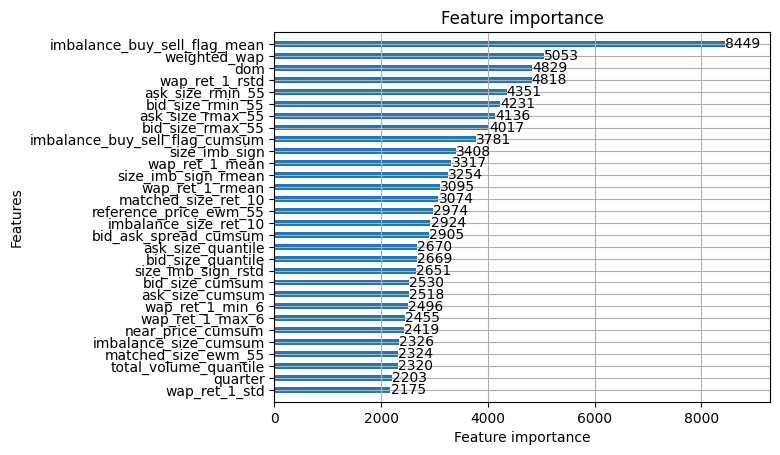

In [ ]:
lgb.plot_importance(model, height = 0.5, max_num_features=30)

In [ ]:
feature_importance = dict(zip(X_train.columns, model.feature_importance()))
feature_importance = dict(sorted(feature_importance.items(), key=lambda x: x[1])[::-1])
feats_list = list(feature_importance.keys())
#feature_importance
feats_list

['imbalance_buy_sell_flag_mean',
 'weighted_wap',
 'dom',
 'wap_ret_1_rstd',
 'ask_size_rmin_55',
 'bid_size_rmin_55',
 'ask_size_rmax_55',
 'bid_size_rmax_55',
 'imbalance_buy_sell_flag_cumsum',
 'size_imb_sign',
 'wap_ret_1_mean',
 'size_imb_sign_rmean',
 'wap_ret_1_rmean',
 'matched_size_ret_10',
 'reference_price_ewm_55',
 'imbalance_size_ret_10',
 'bid_ask_spread_cumsum',
 'ask_size_quantile',
 'bid_size_quantile',
 'size_imb_sign_rstd',
 'bid_size_cumsum',
 'ask_size_cumsum',
 'wap_ret_1_min_6',
 'wap_ret_1_max_6',
 'near_price_cumsum',
 'imbalance_size_cumsum',
 'matched_size_ewm_55',
 'total_volume_quantile',
 'quarter',
 'wap_ret_1_std',
 'reference_price_shift_10',
 'size_imb_spread',
 'far_price_cumsum',
 'wap_ret_1_kurtosis',
 'wap_ret_1_skew',
 'dow',
 'reference_price_wap_imb',
 'matched_size_shift_10',
 'imbalance_size_shift_10',
 'wap_ret_1_absvol',
 'reference_price_ewm_27',
 'matched_size_ret_5',
 'far_price_diff_10',
 'imbalance_size_ret_5',
 'all_sizes_mean',
 'all_

In [ ]:
[(x,feature_importance[x]) for x in feats_list if 'abs' in x]

[('wap_ret_1_absvol', 1731)]

In [ ]:
!cp -r /content/lgb_model_0 "/content/drive/MyDrive/Colab Notebooks/Optiver/data/LightGBM_models"
!cp -r /content/lgb_model_1 "/content/drive/MyDrive/Colab Notebooks/Optiver/data/LightGBM_models"
!cp -r /content/lgb_model_2 "/content/drive/MyDrive/Colab Notebooks/Optiver/data/LightGBM_models"
!cp -r /content/lgb_model_3 "/content/drive/MyDrive/Colab Notebooks/Optiver/data/LightGBM_models"
!cp -r /content/lgb_model_4 "/content/drive/MyDrive/Colab Notebooks/Optiver/data/LightGBM_models"

!cp -r /content/lgb_model_5 "/content/drive/MyDrive/Colab Notebooks/Optiver/data/LightGBM_models"
!cp -r /content/lgb_model_6 "/content/drive/MyDrive/Colab Notebooks/Optiver/data/LightGBM_models"
!cp -r /content/lgb_model_7 "/content/drive/MyDrive/Colab Notebooks/Optiver/data/LightGBM_models"
!cp -r /content/lgb_model_8 "/content/drive/MyDrive/Colab Notebooks/Optiver/data/LightGBM_models"
!cp -r /content/lgb_model_9 "/content/drive/MyDrive/Colab Notebooks/Optiver/data/LightGBM_models"

cp: cannot stat '/content/lgb_model_1': No such file or directory
cp: cannot stat '/content/lgb_model_2': No such file or directory
cp: cannot stat '/content/lgb_model_3': No such file or directory
cp: cannot stat '/content/lgb_model_4': No such file or directory
cp: cannot stat '/content/lgb_model_5': No such file or directory
cp: cannot stat '/content/lgb_model_6': No such file or directory
cp: cannot stat '/content/lgb_model_7': No such file or directory
cp: cannot stat '/content/lgb_model_8': No such file or directory
cp: cannot stat '/content/lgb_model_9': No such file or directory
